# Generate MRR & Count vs Combo size Plot

In [1]:
import polars as pl
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns

import os

## Import and Process datasets

### import data

In [2]:
os.chdir("./Notebooks")

In [3]:
intersect = pl.read_parquet("./data_output/intersection_method_combinations.parquet")
union = pl.read_parquet("./data_output/union_method_combinations.parquet")

In [4]:
intersect.head(2)

h,method,answers,is_answer,rank,filt_rank,method_size
str,list[str],str,bool,f64,u32,u32
"""CHEBI:8714""","[""CBR"", ""TransE""]","""DOID:60164""",false,48.0,17,2
"""CHEBI:8714""","[""CBR"", ""TransE""]","""DOID:10763""",true,2.5,1,2


In [5]:
union.head(2)

h,method,answers,rank,is_answer,filt_rank,method_size
str,list[str],str,f64,bool,u32,u32
"""CHEBI:63638""","[""TransE"", ""CBR""]","""DOID:12849""",1.0,false,1,2
"""CHEBI:63638""","[""TransE"", ""CBR""]","""DOID:1826""",3.0,true,2,2


### add identifier as intersect or union

In [6]:
intersect = intersect.with_columns(pl.lit("Intersection").alias("group"))
union = union.with_columns(pl.lit("Union").alias("group")).select(
    ["h", "method", "answers", "is_answer", "rank", "filt_rank", "method_size", "group"]
)

In [7]:
combined = pl.concat([intersect, union])

## Gather stats

In [8]:
combined.head(2)

h,method,answers,is_answer,rank,filt_rank,method_size,group
str,list[str],str,bool,f64,u32,u32,str
"""CHEBI:8714""","[""CBR"", ""TransE""]","""DOID:60164""",false,48.0,17,2,"""Intersection"""
"""CHEBI:8714""","[""CBR"", ""TransE""]","""DOID:10763""",true,2.5,1,2,"""Intersection"""


In [9]:
known_true_df = (
    combined.filter(pl.col("is_answer") == True)
    .group_by(["group", "method_size"])
    .agg("filt_rank")
    .with_columns(
        pl.col("filt_rank").list.len().alias("counts"),
        pl.col("filt_rank").list.eval(1 / pl.element()).list.mean().alias("mrr"),
    )
)

known_true_df

group,method_size,filt_rank,counts,mrr
str,u32,list[u32],u32,f64
"""Intersection""",3,"[1, 7, … 1]",10449,0.545053
"""Intersection""",6,"[1, 2, … 1]",750,0.869422
"""Intersection""",2,"[1, 14, … 2]",6858,0.43649
"""Union""",6,"[1, 2, … 44]",17498,0.161977
"""Union""",3,"[1, 3, … 14]",64266,0.165189
…,…,…,…,…
"""Union""",5,"[1, 2, … 15]",50860,0.161451
"""Union""",7,"[1, 2, … 38]",2560,0.16325
"""Intersection""",4,"[1, 1, … 1]",7925,0.640201


In [10]:
known_true_df.filter(pl.col("method_size") == 7)

group,method_size,filt_rank,counts,mrr
str,u32,list[u32],u32,f64
"""Union""",7,"[1, 2, … 38]",2560,0.16325
"""Intersection""",7,"[1, 1, … 1]",83,0.949799


## plot

### convert to pandas for plotting

In [12]:
known_true_df_pd = known_true_df.to_pandas()

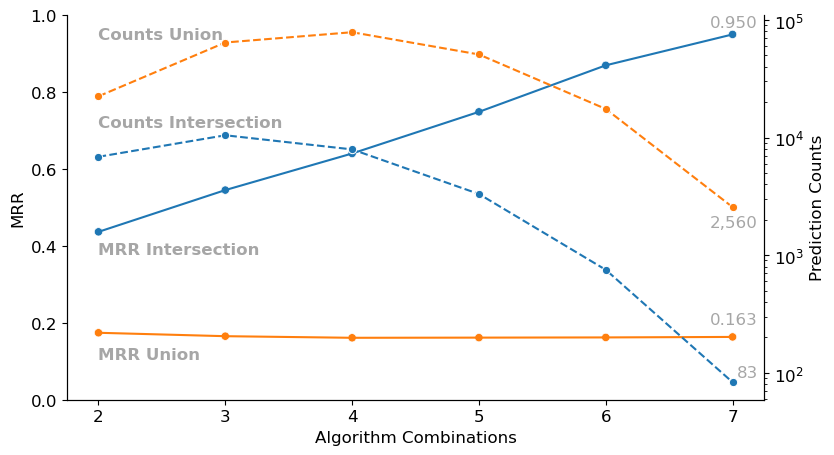

In [49]:
# MRR vs Prediction Counts on Algorithm Intersection/Union
plt.rcParams["font.size"] = 12
fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()

# plots
sns.lineplot(
    data=known_true_df_pd, x="method_size", y="mrr", hue="group", markers="o", ax=ax1
)
sns.scatterplot(
    data=known_true_df_pd, x="method_size", y="mrr", hue="group", markers="o", ax=ax1
)
sns.lineplot(
    data=known_true_df_pd,
    x="method_size",
    y="counts",
    hue="group",
    marker="o",
    ax=ax2,
    linestyle="--",
)

# labels & spines
ax1.set(xlabel="Algorithm Combinations", ylabel="MRR", ylim=(0, 1.001))
ax2.set(ylabel="Prediction Counts", yscale="log")
ax1.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)


# Get the handles and labels

ax1.annotate(
    "MRR Intersection",
    xy=(2, 0.371),
    ha="left",
    va="bottom",
    color="black",
    alpha=0.35,
    weight="bold",
)
ax1.annotate(
    "MRR Union",
    xy=(2, 0.099),
    ha="left",
    va="bottom",
    color="black",
    alpha=0.35,
    weight="bold",
)
ax1.annotate(
    "Counts Union",
    xy=(2, 0.93),
    ha="left",
    va="bottom",
    color="black",
    alpha=0.35,
    weight="bold",
)
ax1.annotate(
    "Counts Intersection",
    xy=(2, 0.70),
    ha="left",
    va="bottom",
    color="black",
    alpha=0.35,
    weight="bold",
)
# more text labels
## Union/Intersection Count 6
# ax1.annotate("17,498", xy=(6, 0.77), ha="left", va="bottom", alpha=0.35)
# ax1.annotate("750", xy=(6, 0.36), ha="left", va="bottom", alpha=0.35)

# ## Union/Intersection MRR 6
# ax1.annotate("0.162", xy=(6.2, 0.19), ha="right", va="bottom", alpha=0.35)
# ax1.annotate("0.869", xy=(6.2, 0.89), ha="right", va="bottom", alpha=0.35)

## Union/Intersection Count 7
ax1.annotate("2,560", xy=(7.2, 0.44), ha="right", va="bottom", alpha=0.35)
ax1.annotate("83", xy=(7.2, 0.05), ha="right", va="bottom", alpha=0.35)

## Union/Intersection MRR 7
ax1.annotate("0.163", xy=(7.2, 0.19), ha="right", va="bottom", alpha=0.35)
ax1.annotate("0.950", xy=(7.2, 0.96), ha="right", va="bottom", alpha=0.35)


# Manipulate the Legend
ax1.get_legend().remove()
ax2.get_legend().remove()

plt.savefig(
    "./figures/union_v_intersect_ensemble_rank_endpt.png", dpi=400, bbox_inches="tight"
)
plt.show()

In [103]:
known_true_df.filter(pl.col("method_size") == 5)

group,method_size,filt_rank,counts,mrr
str,u32,list[u32],u32,f64
"""Intersection""",5,"[1, 1, … 1]",3309,0.748475
"""Union""",5,"[1, 2, … 15]",50860,0.161451


## Seperate plots into two

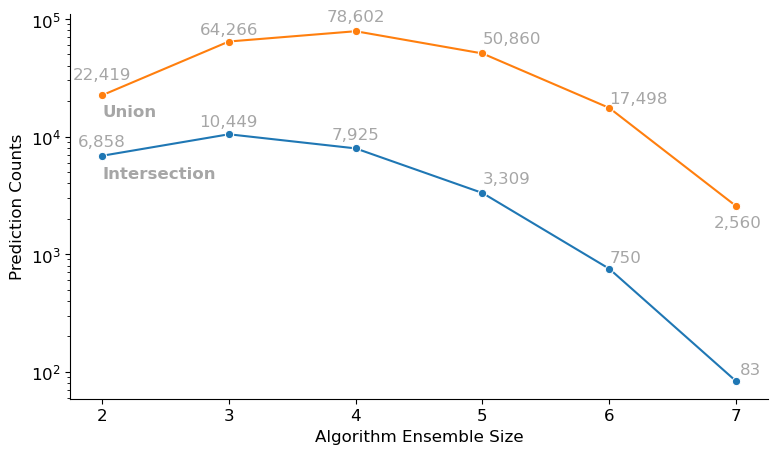

In [107]:
# MRR vs Prediction Counts on Algorithm Intersection/Union
plt.rcParams["font.size"] = 12
fig, ax1 = plt.subplots(figsize=(9, 5))
# plots

# sns.scatterplot(
#     data=known_true_df_pd, x="method_size", y="mrr", hue="group", markers="o", ax=ax1
# )
sns.lineplot(
    data=known_true_df_pd,
    x="method_size",
    y="counts",
    hue="group",
    marker="o",
    ax=ax1,
    # linestyle="--",
)

# labels & spines
ax1.set(xlabel="Algorithm Ensemble Size", ylabel="Prediction Counts", yscale="log")
ax1.spines[["top", "right"]].set_visible(False)


# Get the handles and labels

ax1.annotate(
    "Union",
    xy=(2, 13900),
    ha="left",
    va="bottom",
    color="black",
    alpha=0.35,
    weight="bold",
)
ax1.annotate(
    "Intersection",
    xy=(2, 4200),
    ha="left",
    va="bottom",
    color="black",
    alpha=0.35,
    weight="bold",
)
# more text labels
## Union/Intersection Count 2
ax1.annotate("22,419", xy=(2, 29000), ha="center", va="bottom", alpha=0.35)
ax1.annotate("6,858", xy=(2, 7800), ha="center", va="bottom", alpha=0.35)

## Union/Intersection Count 3
ax1.annotate("64,266", xy=(3, 70000), ha="center", va="bottom", alpha=0.35)
ax1.annotate("10,449", xy=(3, 11500), ha="center", va="bottom", alpha=0.35)

## Union/Intersection Count 4
ax1.annotate("78,602", xy=(4, 90000), ha="center", va="bottom", alpha=0.35)
ax1.annotate("7,925", xy=(4, 9000), ha="center", va="bottom", alpha=0.35)

## Union/Intersection Count 5
ax1.annotate("50,860", xy=(5, 59000), ha="left", va="bottom", alpha=0.35)
ax1.annotate("3,309", xy=(5, 3800), ha="left", va="bottom", alpha=0.35)

## Union/Intersection Count 6
ax1.annotate("17,498", xy=(6, 18000), ha="left", va="bottom", alpha=0.35)
ax1.annotate("750", xy=(6, 800), ha="left", va="bottom", alpha=0.35)

## Union/Intersection Count 7
ax1.annotate("2,560", xy=(7.2, 1600), ha="right", va="bottom", alpha=0.35)
ax1.annotate("83", xy=(7.2, 90), ha="right", va="bottom", alpha=0.35)

# Manipulate the Legend
ax1.get_legend().remove()


plt.savefig(
    "./figures/union_v_intersect_ensemble_rank_predcount.png",
    dpi=400,
    bbox_inches="tight",
)
plt.show()

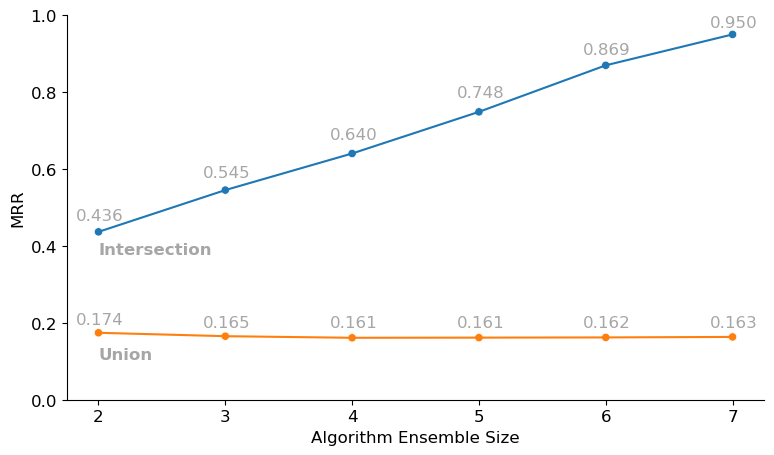

In [108]:
# MRR vs Prediction Counts on Algorithm Intersection/Union
plt.rcParams["font.size"] = 12
fig, ax1 = plt.subplots(figsize=(9, 5))

# plots
sns.lineplot(
    data=known_true_df_pd, x="method_size", y="mrr", hue="group", markers="o", ax=ax1
)
sns.scatterplot(
    data=known_true_df_pd, x="method_size", y="mrr", hue="group", markers="o", ax=ax1
)

# labels & spines
ax1.set(xlabel="Algorithm Ensemble Size", ylabel="MRR", ylim=(0, 1.001))
ax1.spines[["top", "right"]].set_visible(False)


# Get the handles and labels

ax1.annotate(
    "Intersection",
    xy=(2, 0.371),
    ha="left",
    va="bottom",
    color="black",
    alpha=0.35,
    weight="bold",
)
ax1.annotate(
    "Union",
    xy=(2, 0.099),
    ha="left",
    va="bottom",
    color="black",
    alpha=0.35,
    weight="bold",
)

# more text labels
## Union/Intersection MRR 2
ax1.annotate("0.174", xy=(2.2, 0.19), ha="right", va="bottom", alpha=0.35)
ax1.annotate("0.436", xy=(2.2, 0.46), ha="right", va="bottom", alpha=0.35)

## Union/Intersection MRR 3
ax1.annotate("0.165", xy=(3.2, 0.18), ha="right", va="bottom", alpha=0.35)
ax1.annotate("0.545", xy=(3.2, 0.57), ha="right", va="bottom", alpha=0.35)

## Union/Intersection MRR 4
ax1.annotate("0.161", xy=(4.2, 0.18), ha="right", va="bottom", alpha=0.35)
ax1.annotate("0.640", xy=(4.2, 0.67), ha="right", va="bottom", alpha=0.35)

## Union/Intersection MRR 5
ax1.annotate("0.161", xy=(5.2, 0.18), ha="right", va="bottom", alpha=0.35)
ax1.annotate("0.748", xy=(5.2, 0.78), ha="right", va="bottom", alpha=0.35)

## Union/Intersection MRR 6
ax1.annotate("0.162", xy=(6.2, 0.18), ha="right", va="bottom", alpha=0.35)
ax1.annotate("0.869", xy=(6.2, 0.89), ha="right", va="bottom", alpha=0.35)

## Union/Intersection MRR 7
ax1.annotate("0.163", xy=(7.2, 0.18), ha="right", va="bottom", alpha=0.35)
ax1.annotate("0.950", xy=(7.2, 0.96), ha="right", va="bottom", alpha=0.35)


# Manipulate the Legend
ax1.get_legend().remove()


plt.savefig(
    "./figures/union_v_intersect_ensemble_rank_mrr.png", dpi=400, bbox_inches="tight"
)
plt.show()